In [32]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
import seaborn as sns
from tqdm import tqdm

# Load csv

## data daily

In [ ]:
base_path = "data_daily/"

data_daily_df = pd.DataFrame()

for year in range(2010, 2015):
    for month in range(1, 13):
        for day in range(1, 32):
            file_path = os.path.join(base_path, f"dat.{year}{month:02d}{day:02d}.csv")

            if os.path.exists(file_path):
                try:
                    data = pd.read_csv(file_path)
                    data_daily_df = pd.concat([data_daily_df, data], ignore_index=True)
                except Exception as e:
                    print(f"Error reading {file_path}: {e}")

In [ ]:
data_daily_df.to_csv('data_daily_df.csv', index=False)

In [2]:
data_daily_df = pd.read_csv('data_daily_df.csv')
data_daily_df['Date'] = pd.to_datetime(data_daily_df['Date'], format='%Y%m%d')

### adj data daily

In [3]:
def adjust_prices(group):
    base_factor = group.iloc[-1]['PxAdjFactor']
    group = group.copy()
    group['adj_open']  = group['Open']  * (base_factor / group['PxAdjFactor'])
    group['adj_high']  = group['High']  * (base_factor / group['PxAdjFactor'])
    group['adj_low']   = group['Low']   * (base_factor / group['PxAdjFactor'])
    group['adj_close'] = group['Close'] * (base_factor / group['PxAdjFactor'])
    return group

data_daily_df = data_daily_df.groupby('ID', group_keys=False).apply(adjust_prices)

In [4]:
def adjust_volume(group):
    base_shares_factor = group.iloc[-1]['SharesAdjFactor']
    group = group.copy()
    group['adj_volume'] = group['Volume'] * (base_shares_factor / group['SharesAdjFactor'])
    return group

data_daily_df = data_daily_df.groupby('ID', group_keys=False).apply(adjust_volume)

### return

In [5]:
data_daily_df['return'] = data_daily_df.groupby('ID')['adj_close'].transform(lambda x: (x / x.shift(1) - 1))

### weight

In [6]:
data_daily_df['weight'] = np.sqrt(data_daily_df['MDV_63'])

### save edited dataframe

In [8]:
data_daily_df.to_csv('edited_data_daily_df.csv', index=False)

In [9]:
data_daily_df = pd.read_csv('edited_data_daily_df.csv')

## data intraday

In [ ]:
base_path = "data_intraday/"

data_intraday_df = pd.DataFrame()

for year in range(2010, 2015):
    for month in range(1, 13):
        for day in range(1, 32):
            file_path = os.path.join(base_path, f"{year}{month:02d}{day:02d}.csv")

            if os.path.exists(file_path):
                try:
                    data = pd.read_csv(file_path)
                    data_intraday_df = pd.concat([data_intraday_df, data], ignore_index=True)
                except Exception as e:
                    print(f"Error reading {file_path}: {e}")

In [ ]:
data_intraday_df.to_csv('data_intraday_df.csv', index=False)

In [10]:
data_intraday_df = pd.read_csv('data_intraday_df.csv')
data_intraday_df['Date'] = pd.to_datetime(data_intraday_df['Date'], format='%Y%m%d')
data_intraday_df['Time'] = data_intraday_df['Time'].str[:5]

### pivot

In [11]:
# Change to wide form table
data_intraday_df = data_intraday_df.pivot_table(
    index=['Date', 'Id'],
    columns='Time',
    values=['CumReturnResid', 'CumReturnRaw', 'CumVolume']
)
data_intraday_df.columns = [f"{var}_{time}" for var, time in data_intraday_df.columns]
data_intraday_df = data_intraday_df.reset_index()

In [40]:
data_intraday_df.head()

,Date,Id,CumReturnRaw_09:45,CumReturnRaw_10:00,CumReturnRaw_10:15,CumReturnRaw_10:30,CumReturnRaw_10:45,CumReturnRaw_11:00,CumReturnRaw_11:15,CumReturnRaw_11:30,...,CumVolume_13:45,CumVolume_14:00,CumVolume_14:15,CumVolume_14:30,CumVolume_14:45,CumVolume_15:00,CumVolume_15:15,CumVolume_15:30,CumVolume_15:45,CumVolume_16:00
0,2010-01-04,BBG000B9WH86,0.021705,0.024186,0.037209,0.043411,0.041551,0.035969,0.034109,0.036590,...,18319154,18943352,19565588,20044828,20683356,21109560,21664756,22197704,23162596,25160630
1,2010-01-04,BBG000B9WJ73,0.029650,0.030998,0.042228,0.044474,0.050539,0.047844,0.050988,0.046496,...,2145103,2247552,2320463,2415533,2500430,2622971,2803886,2959772,3221438,3780092
2,2010-01-04,BBG000B9XRY4,0.015086,0.011931,0.010129,0.012999,0.013284,0.012074,0.011576,0.012430,...,12178250,12486499,12790198,13039100,13419996,13821269,14254671,15025785,15591479,16629073
3,2010-01-04,BBG000B9XYV2,0.014481,0.014713,0.011469,0.012164,0.010310,0.009152,0.010079,0.009152,...,1558707,1622068,1679508,1731335,1787940,1872126,2127369,2243327,2385796,2588493
4,2010-01-04,BBG000B9YJ35,0.004877,-0.000759,0.000108,0.000217,0.000217,-0.000867,-0.001734,-0.002168,...,805295,827067,841946,861878,891715,922622,964398,1012371,1070733,1178894


### interval return and volume

In [23]:
times = ['09:45', '10:00', '10:15', '10:30', '10:45', 
         '11:00', '11:15', '11:30', '11:45', '12:00', 
         '12:15', '12:30', '12:45', '13:00', '13:15', 
         '13:30', '13:45', '14:00', '14:15', '14:30', 
         '14:45', '15:00', '15:15', '15:30', '15:45', '16:00']

In [13]:
data_intraday_df['ReturnResid_09:45'] = data_intraday_df['CumReturnResid_09:45']
for i in range(1, len(times)):
    start = times[i-1]
    end = times[i]
    data_intraday_df[f'ReturnResid_{end}'] = (data_intraday_df[f'CumReturnResid_{end}'] + 1) / (data_intraday_df[f'CumReturnResid_{start}'] + 1) - 1

In [98]:
data_intraday_df['ReturnRaw_09:45'] = data_intraday_df['CumReturnRaw_09:45']
for i in range(1, len(times)):
    start = times[i-1]
    end = times[i]
    data_intraday_df[f'ReturnRaw_{end}'] = (data_intraday_df[f'CumReturnRaw_{end}'] + 1) / (data_intraday_df[f'CumReturnResid_{start}'] + 1) - 1

In [14]:
data_intraday_df['Volume_09:45'] = data_intraday_df['CumVolume_09:45']
for i in range(1, len(times)):
    start = times[i-1]
    end = times[i]
    data_intraday_df[f'Volume_{end}'] = data_intraday_df[f'CumVolume_{end}'] - data_intraday_df[f'CumVolume_{start}']

### plot volumes and returns

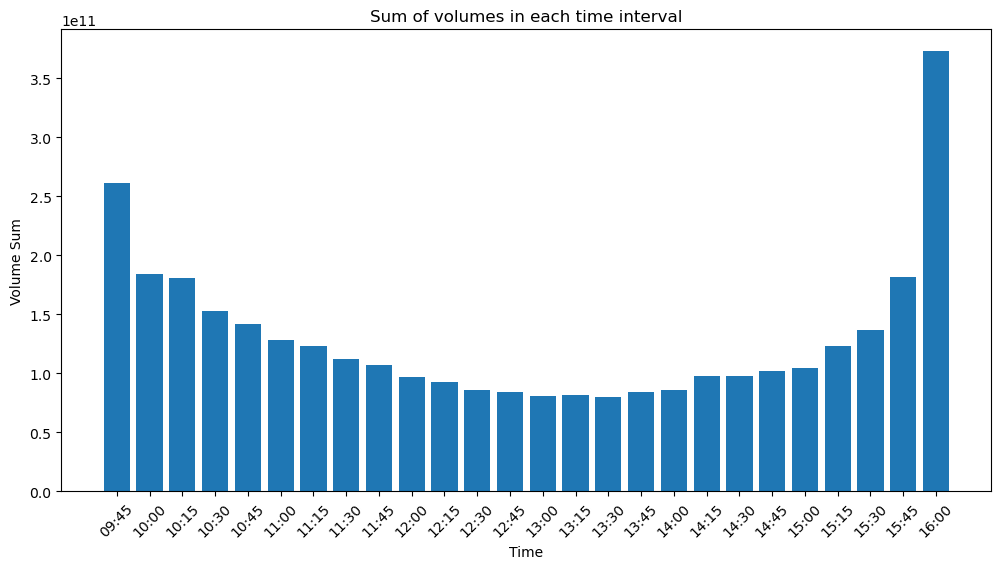

In [30]:
volume_cols = ['Volume_' + t for t in times]
volume_sums = data_intraday_df[volume_cols].sum()

plt.figure(figsize=(12,6))
plt.bar(times, volume_sums, capsize=5)
plt.xlabel('Time')
plt.ylabel('Volume Sum')
plt.title('Sum of volumes in each time interval')
plt.xticks(rotation=45)
plt.show()

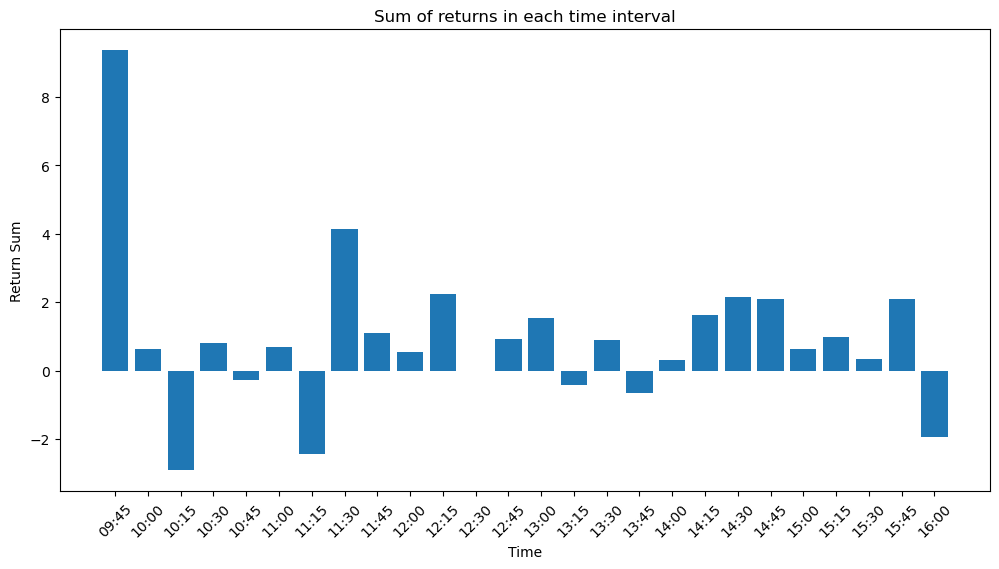

In [31]:
return_cols = ['ReturnResid_' + t for t in times]
return_sums = data_intraday_df[return_cols].sum()

plt.figure(figsize=(12,6))
plt.bar(times, return_sums, capsize=5)
plt.xlabel('Time')
plt.ylabel('Return Sum')
plt.title('Sum of returns in each time interval')
plt.xticks(rotation=45)
plt.show()

Thoughts about intraday volumes and returns:

Split the whole day into 5 intervals:
- 9:30 - 10:00
- 10:00 - 11:30
- 11:30 - 13:30
- 13:30 - 15:30
- 15:30 - 16:00

### save edited dataframe

In [15]:
data_intraday_df.to_csv('edited_data_intraday_df.csv', index=False)

In [5]:
data_intraday_df = pd.read_csv('edited_data_intraday_df.csv')

# y

In [34]:
data_intraday_df['y'] = (
    data_intraday_df.groupby('Id')
    .apply(lambda g: (g['CumReturnResid_16:00'] + 1) / (g['CumReturnResid_15:30'] + 1) * (g['CumReturnResid_15:30'].shift(-1) + 1) - 1)
    .reset_index(level=0, drop=True)
)

In [38]:
data_intraday_df['y_RawReturn'] = (
    data_intraday_df.groupby('Id')
    .apply(lambda g: (g['CumReturnRaw_16:00'] + 1) / (g['CumReturnRaw_15:30'] + 1) * (g['CumReturnRaw_15:30'].shift(-1) + 1) - 1)
    .reset_index(level=0, drop=True)
)

# Momentum

Features related to momentum / reversal (returns)

## 5-Day Cumulative Residual Return

Cumulative sum of residual returns over the past
five days

In [35]:
data_intraday_df['cum_return_prev5d'] = data_intraday_df.groupby('Id')['CumReturnResid_16:00'].transform(
    lambda x: x.shift(1).rolling(window=5, min_periods=5).apply(lambda y: np.nanprod(1 + y) - 1, raw=True)
)

## 21-Day Cumulative Residual Return

In [36]:
data_intraday_df['cum_return_prev21d'] = data_intraday_df.groupby('Id')['CumReturnResid_16:00'].transform(
    lambda x: x.shift(1).rolling(window=21, min_periods=21).apply(lambda y: np.nanprod(1 + y) - 1, raw=True)
)

## 63-Day Cumulative Residual Return

In [37]:
data_intraday_df['cum_return_prev63d'] = data_intraday_df.groupby('Id')['CumReturnResid_16:00'].transform(
    lambda x: x.shift(1).rolling(window=63, min_periods=63).apply(lambda y: np.nanprod(1 + y) - 1, raw=True)
)

## Correlation plot

Intraday momentum

In [ ]:
times = [
    '09:45', '10:00', '10:15', '10:30', '10:45',
    '11:00', '11:15', '11:30', '11:45', '12:00',
    '12:15', '12:30', '12:45', '13:00', '13:15',
    '13:30', '13:45', '14:00', '14:15', '14:30',
    '14:45', '15:00', '15:15', '15:30', '15:45', '16:00'
]
returnresid_cols = [f"ReturnResid_{t}" for t in times]
n = len(times)

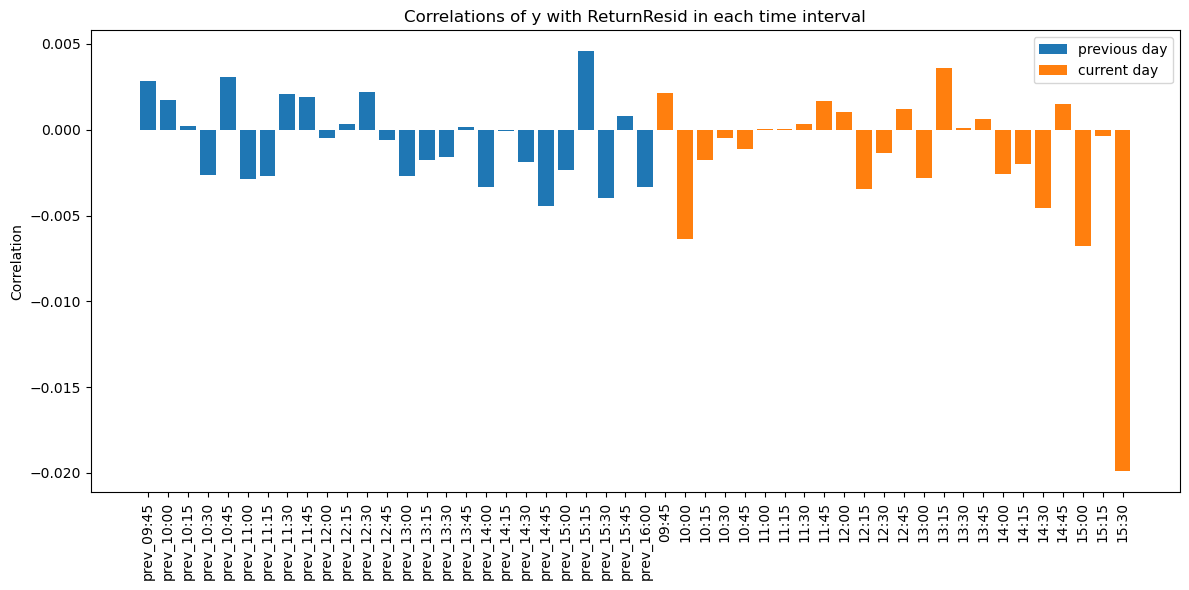

In [85]:
corr_current = []
corr_prev = []
for col in returnresid_cols:
    corr_current.append(data_intraday_df['y'].corr(data_intraday_df[col]))
    corr_prev.append(data_intraday_df['y'].corr(data_intraday_df.groupby('Id')[col].shift(1)))
corr_current = corr_current[:-2]

x_ticks = np.arange(2 * n - 2)
x_tick_labels = [f"prev_{t}" for t in times] + times[:-2]
fig, ax = plt.subplots(figsize=(12,6))
ax.bar(np.arange(n), corr_prev, width=0.8, label='previous day')
ax.bar(np.arange(n, 2 * n - 2), corr_current, width=0.8, label='current day')
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_tick_labels, rotation=90)
ax.set_ylabel('Correlation')
ax.set_title("Correlations of y with ReturnResid in each time interval")
ax.legend()
plt.show()

Split the whole day into 5 intervals:
- 9:30 - 10:00
- 10:00 - 11:30
- 11:30 - 13:30
- 13:30 - 15:30
- 15:30 - 16:00

Thought:
- Should not use ReturnResid_15:30, because it and y both used Close_15:30
- Relations are pretty random
- Split the cumulative returns into several intervals
- Use cumulative relative volumes in each interval as features

## Residual Return in intraday intervals

In [30]:
# Current day returns in time intervals
data_intraday_df['cum_return_13:30_15:15'] = (
    (data_intraday_df['CumReturnResid_15:15'] + 1) / (data_intraday_df['CumReturnResid_13:30'] + 1) - 1
)
data_intraday_df['cum_return_11:30_13:30'] = (
    (data_intraday_df['CumReturnResid_13:30'] + 1) / (data_intraday_df['CumReturnResid_11:30'] + 1) - 1
)
data_intraday_df['cum_return_10:00_11:30'] = (
    (data_intraday_df['CumReturnResid_11:30'] + 1) / (data_intraday_df['CumReturnResid_10:00'] + 1) - 1
)
data_intraday_df['cum_return_09:30_10:00'] = data_intraday_df['CumReturnResid_10:00']

# Previous day return
data_intraday_df['cum_return_prev1d'] = data_intraday_df.groupby('Id')['CumReturnResid_16:00'].shift(1)

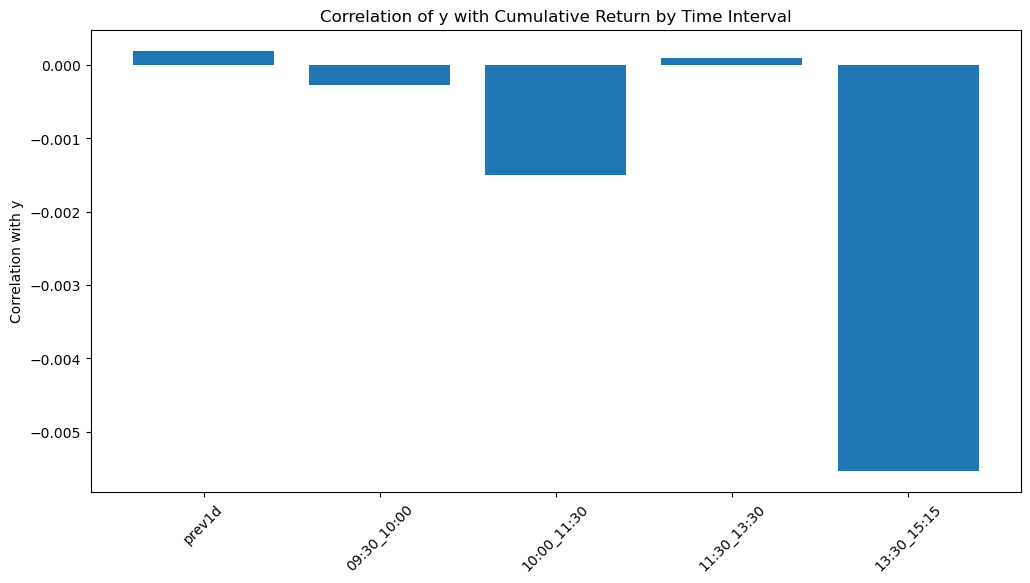

In [35]:
cum_return_cols = [
    'cum_return_prev1d', 'cum_return_09:30_10:00', 'cum_return_10:00_11:30',
    'cum_return_11:30_13:30', 'cum_return_13:30_15:15'
]
correlations = [data_intraday_df['y'].corr(data_intraday_df[col]) for col in cum_return_cols]

fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(np.arange(len(cum_return_cols)), correlations)
x_tick_labels = [col.replace('cum_return_', '') for col in cum_return_cols]
ax.set_xticks(np.arange(len(cum_return_cols)))
ax.set_xticklabels(x_tick_labels, rotation=45)
ax.set_ylabel('Correlation with y')
ax.set_title("Correlation of y with Cumulative Return by Time Interval")
plt.show()

# Volume

Features related to volume

## Calculate 5d mean volume

Use for calculating relative volume. Not a feature

In [53]:
data_intraday_df['avg_vol_prev5d'] = data_intraday_df.groupby('Id')['CumVolume_16:00'].transform(
    lambda x: x.shift(1).rolling(window=5, min_periods=5).apply(lambda y: np.nanmean(y), raw=True)
)

## Correlation plot

In [58]:
times = ['09:45', '10:00', '10:15', '10:30', '10:45', 
         '11:00', '11:15', '11:30', '11:45', '12:00', 
         '12:15', '12:30', '12:45', '13:00', '13:15', 
         '13:30', '13:45', '14:00', '14:15', '14:30', 
         '14:45', '15:00', '15:15', '15:30', '15:45', '16:00']
volume_cols = ['Volume_' + t for t in times]
n = len(times)

Correlation of y with raw volumes in each time interval

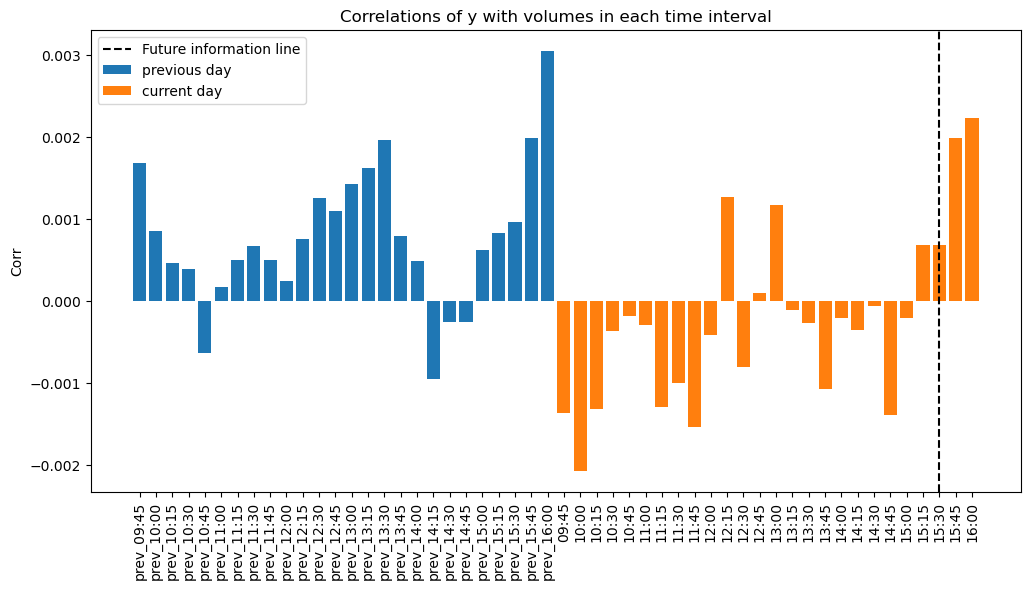

In [ ]:
corr_current = []
corr_prev = []
for col in volume_cols:
    corr_current.append(data_intraday_df['y'].corr(data_intraday_df[col]))
    corr_prev.append(data_intraday_df['y'].corr(data_intraday_df.groupby('Id')[col].shift(1)))

fig, ax = plt.subplots(figsize=(12,6))
bars_prev = ax.bar(np.arange(n), corr_prev, width=0.8, label='previous day')
bars_curr = ax.bar(np.arange(n, 2*n), corr_current, width=0.8, label='current day')
x_ticks = np.arange(2*n)
x_tick_labels = [f"prev_{t}" for t in times] + times
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_tick_labels, rotation=90)
ax.axvline(x=49, color='black', linestyle='--', label='Future information line')
ax.set_ylabel('Corr')
ax.set_title("Correlations of y with volumes in each time interval")
ax.legend()
plt.show()

Relative volumes : interval volume / 5d average volume

Correlation of y with relative volumes in each time interval

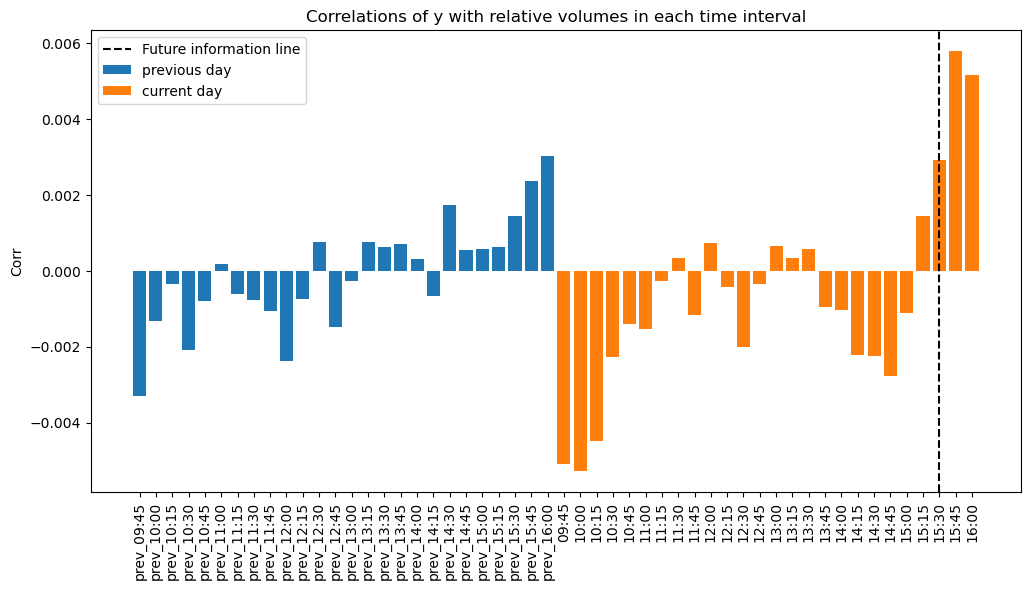

In [ ]:
corr_current = []
corr_prev = []
for col in volume_cols:
    corr_current.append(data_intraday_df['y'].corr(data_intraday_df[col] / data_intraday_df['avg_vol_prev5d']))
    corr_prev.append(data_intraday_df['y'].corr(data_intraday_df.groupby('Id')[col].shift(1) / data_intraday_df['avg_vol_prev5d']))

fig, ax = plt.subplots(figsize=(12,6))
bars_prev = ax.bar(np.arange(n), corr_prev, width=0.8, label='previous day')
bars_curr = ax.bar(np.arange(n, 2*n), corr_current, width=0.8, label='current day')
x_ticks = np.arange(2*n)
x_tick_labels = [f"prev_{t}" for t in times] + times
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_tick_labels, rotation=90)
ax.set_ylabel('Corr')
ax.axvline(x=49, color='black', linestyle='--', label='Future information line')
ax.set_title("Correlations of y with relative volumes in each time interval")
ax.legend()
plt.show()

Split the whole day into 5 intervals:
- 9:30 - 10:00
- 10:00 - 11:30
- 11:30 - 13:30
- 13:30 - 15:30
- 15:30 - 16:00

Thought:
- Better to use relative volumes
- Use cumulative relative volumes in each interval as features

## Relative Volume at 15:30

$V_{relative,15:30} =\frac{V_{15:30}}{\text{mean}(V_{t−1}, V_{t−2}, V_{t−3}, V_{t−4}, V_{t−5})}$

In [ ]:
data_intraday_df['relative_volume_15:30'] = data_intraday_df['CumVolume_15:30'] / data_intraday_df['avg_vol_prev5d']

## Relative Volume in intraday intervals

Cumulative relative volumes in each interval

In [60]:
# Current day volumes in time intervals
data_intraday_df['relative_volume_13:30_15:30'] = (
    data_intraday_df['CumVolume_15:30'] - data_intraday_df['CumVolume_13:30']
) / data_intraday_df['avg_vol_prev5d']

data_intraday_df['relative_volume_11:30_13:30'] = (
    data_intraday_df['CumVolume_13:30'] - data_intraday_df['CumVolume_11:30']
) / data_intraday_df['avg_vol_prev5d']

data_intraday_df['relative_volume_10:00_11:30'] = (
    data_intraday_df['CumVolume_11:30'] - data_intraday_df['CumVolume_10:00']
) / data_intraday_df['avg_vol_prev5d']

data_intraday_df['relative_volume_09:30_10:00'] = (
    data_intraday_df['CumVolume_10:00']
) / data_intraday_df['avg_vol_prev5d']

# Previous day volumes in 3 time intervals
cumvol_16_prev   = data_intraday_df.groupby('Id')['CumVolume_16:00'].shift(1)
cumvol_13_30_prev = data_intraday_df.groupby('Id')['CumVolume_13:30'].shift(1)
cumvol_11_30_prev = data_intraday_df.groupby('Id')['CumVolume_11:30'].shift(1)

data_intraday_df['relative_volume_prev13:30_16:00'] = (
    cumvol_16_prev - cumvol_13_30_prev
) / data_intraday_df['avg_vol_prev5d']

data_intraday_df['relative_volume_prev11:30_13:30'] = (
    cumvol_13_30_prev - cumvol_11_30_prev
) / data_intraday_df['avg_vol_prev5d']

data_intraday_df['relative_volume_prev09:30_11:30'] = (
    cumvol_11_30_prev
) / data_intraday_df['avg_vol_prev5d']

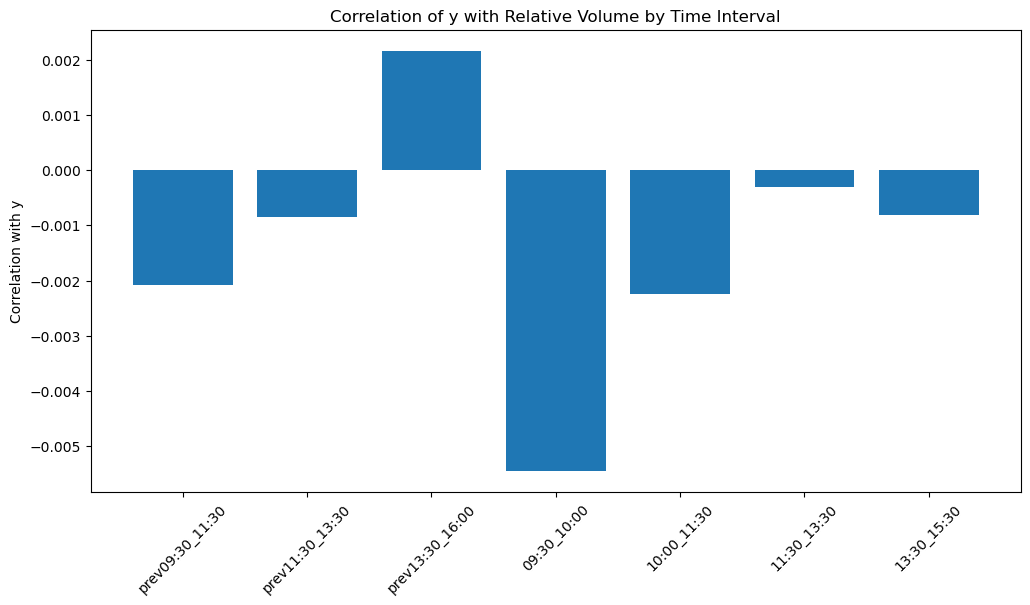

In [63]:
relative_volume_cols = [
    'relative_volume_prev09:30_11:30', 'relative_volume_prev11:30_13:30', 'relative_volume_prev13:30_16:00',
    'relative_volume_09:30_10:00', 'relative_volume_10:00_11:30', 'relative_volume_11:30_13:30', 'relative_volume_13:30_15:30',
]
correlations = [data_intraday_df['y'].corr(data_intraday_df[col]) for col in relative_volume_cols]

fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(np.arange(len(relative_volume_cols)), correlations)
x_tick_labels = [col.replace('relative_volume_', '') for col in relative_volume_cols]
ax.set_xticks(np.arange(len(relative_volume_cols)))
ax.set_xticklabels(x_tick_labels, rotation=45)
ax.set_ylabel('Correlation with y')
ax.set_title("Correlation of y with Relative Volume by Time Interval")
plt.show()

# Relation of volumes and returns

Relation of intraday volumes and residual returns (corr)

In [101]:
times = ['09:45', '10:00', '10:15', '10:30', '10:45', 
         '11:00', '11:15', '11:30', '11:45', '12:00', 
         '12:15', '12:30', '12:45', '13:00', '13:15', 
         '13:30', '13:45', '14:00', '14:15', '14:30', 
         '14:45', '15:00', '15:15']
returns = data_intraday_df[[f'ReturnResid_{time}' for time in times]].to_numpy()
volumes = data_intraday_df[[f'Volume_{time}' for time in times]].to_numpy()

mean_returns = np.nanmean(returns, axis=1, keepdims=True)
mean_volumes = np.nanmean(volumes, axis=1, keepdims=True)
num = np.nansum((returns - mean_returns) * (volumes - mean_volumes), axis=1)
denom = np.sqrt(np.nansum((returns - mean_returns)**2, axis=1) * np.nansum((volumes - mean_volumes)**2, axis=1))
corr = np.where(denom != 0, num/denom, np.nan)

data_intraday_df['volume_resid_return_corr'] = corr

C:\Users\52431\AppData\Local\Temp\ipykernel_17528\942413085.py:9: RuntimeWarning: Mean of empty slice
  mean_returns = np.nanmean(returns, axis=1, keepdims=True)
C:\Users\52431\AppData\Local\Temp\ipykernel_17528\942413085.py:13: RuntimeWarning: invalid value encountered in divide
  corr = np.where(denom != 0, num/denom, np.nan)


Relation of intraday volumes and raw returns (corr)

In [103]:
times = ['09:45', '10:00', '10:15', '10:30', '10:45', 
         '11:00', '11:15', '11:30', '11:45', '12:00', 
         '12:15', '12:30', '12:45', '13:00', '13:15', 
         '13:30', '13:45', '14:00', '14:15', '14:30', 
         '14:45', '15:00', '15:15']
returns = data_intraday_df[[f'ReturnRaw_{time}' for time in times]].to_numpy()
volumes = data_intraday_df[[f'Volume_{time}' for time in times]].to_numpy()

mean_returns = np.nanmean(returns, axis=1, keepdims=True)
mean_volumes = np.nanmean(volumes, axis=1, keepdims=True)
num = np.nansum((returns - mean_returns) * (volumes - mean_volumes), axis=1)
denom = np.sqrt(np.nansum((returns - mean_returns)**2, axis=1) * np.nansum((volumes - mean_volumes)**2, axis=1))
corr = np.where(denom != 0, num/denom, np.nan)

data_intraday_df['volume_raw_return_corr'] = corr

C:\Users\52431\AppData\Local\Temp\ipykernel_17528\2345560097.py:9: RuntimeWarning: Mean of empty slice
  mean_returns = np.nanmean(returns, axis=1, keepdims=True)
C:\Users\52431\AppData\Local\Temp\ipykernel_17528\2345560097.py:13: RuntimeWarning: invalid value encountered in divide
  corr = np.where(denom != 0, num/denom, np.nan)


Correlation of y and return&volume correlation features

In [108]:
data_intraday_df[['y','volume_resid_return_corr','volume_raw_return_corr']].corr()

,y,volume_resid_return_corr,volume_raw_return_corr
y,1.000000,0.004761,0.004948
volume_resid_return_corr,0.004761,1.000000,0.555929
volume_raw_return_corr,0.004948,0.555929,1.000000


# Volatility

Features related to volatility

## 21-Day Rolling Volatility raw

21-day rolling volatility for raw returns

In [42]:
data_daily_df['volatility_21d_raw'] = data_daily_df.groupby('ID')['return'].transform(
    lambda x: x.shift(1).rolling(window=21, min_periods=21).apply(lambda y: np.nanstd(y, ddof=1), raw=True)
)

## 21-Day Rolling Volatility resid

21-day rolling volatility for residual returns

In [44]:
data_intraday_df['volatility_21d_resid'] = data_intraday_df.groupby('Id')['CumReturnResid_16:00'].transform(
    lambda x: x.shift(1).rolling(window=21, min_periods=21).apply(lambda y: np.nanstd(y, ddof=1), raw=True)
)

## 63-Day Rolling Volatility raw

63-day rolling volatility for raw returns

In [43]:
data_daily_df['volatility_63d_raw'] = data_daily_df.groupby('ID')['return'].transform(
    lambda x: x.shift(1).rolling(window=63, min_periods=63).apply(lambda y: np.nanstd(y, ddof=1), raw=True)
)

## 63-Day Rolling Volatility resid

63-day rolling volatility for residual returns

In [45]:
data_intraday_df['volatility_63d_resid'] = data_intraday_df.groupby('Id')['CumReturnResid_16:00'].transform(
    lambda x: x.shift(1).rolling(window=63, min_periods=63).apply(lambda y: np.nanstd(y, ddof=1), raw=True)
)

## hlc ratio

hlc ratio : (high - low) / close

In [39]:
data_daily_df['hlc_ratio'] = (data_daily_df['adj_high'] - data_daily_df['adj_low']) / data_daily_df['adj_close']

In [40]:
# Clean one outlier
data_daily_df.loc[data_daily_df['hlc_ratio'] > 10, 'hlc_ratio'] = 0

hlc ratio 21 days rolling mean

In [41]:
data_daily_df['hlc_21mean'] = data_daily_df.groupby('ID')['hlc_ratio'].transform(
    lambda x: x.shift(1).rolling(window=21, min_periods=21).mean()
)

## 1-Day Rolling Volatility

$\sigma_{1d} = \text{std}(R_{t,9:45},R_{t,10:00}, ...,R_{t,15:15})$

Do not use $R_{t,15:30}$, because $R_{t,15:30}$ and $R_{t,16:00}$, i.e. part of $y$ both used $Close_{t, 15:30}$ to calculate.

In [78]:
times = ['09:45', '10:00', '10:15', '10:30', '10:45', 
         '11:00', '11:15', '11:30', '11:45', '12:00', 
         '12:15', '12:30', '12:45', '13:00', '13:15', 
         '13:30', '13:45', '14:00', '14:15', '14:30', 
         '14:45', '15:00', '15:15']

intraday_cols = ['ReturnResid_' + t for t in times]
data_intraday_df['volatility_1d'] = data_intraday_df[intraday_cols].std(axis=1)

# Skewness

Features related to skewness

## Intraday skewness

In [109]:
times = ['09:45', '10:00', '10:15', '10:30', '10:45', 
         '11:00', '11:15', '11:30', '11:45', '12:00', 
         '12:15', '12:30', '12:45', '13:00', '13:15', 
         '13:30', '13:45', '14:00', '14:15', '14:30', 
         '14:45', '15:00', '15:15']
intraday_cols = ['ReturnResid_' + t for t in times]

data_intraday_df['skewness_1d'] = data_intraday_df[intraday_cols].skew(axis=1)

## 21-Day skewness

In [114]:
data_intraday_df['skewness_21d_resid'] = data_intraday_df.groupby('Id')['CumReturnResid_16:00'].transform(
    lambda x: x.shift(1).rolling(window=21, min_periods=21).skew()
)

C:\Users\52431\anaconda3\Lib\site-packages\pandas\core\window\rolling.py:607: RuntimeWarning: All-NaN slice encountered
  return func(x, start, end, min_periods, *numba_args)


## 63-Day skewness

In [115]:
data_intraday_df['skewness_63d_resid'] = data_intraday_df.groupby('Id')['CumReturnResid_16:00'].transform(
    lambda x: x.shift(1).rolling(window=63, min_periods=63).skew()
)

C:\Users\52431\anaconda3\Lib\site-packages\pandas\core\window\rolling.py:607: RuntimeWarning: All-NaN slice encountered
  return func(x, start, end, min_periods, *numba_args)


# Summary

In [24]:
columns = [
    'Date','Id',
    'y','y_RawReturn','weight',
    'cum_return_prev5d','cum_return_prev21d','cum_return_prev63d','cum_return_prev1d',
    'cum_return_09:30_10:00', 'cum_return_10:00_11:30',
    'cum_return_11:30_13:30', 'cum_return_13:30_15:15',
    'relative_volume_15:30',
    'relative_volume_prev09:30_11:30', 'relative_volume_prev11:30_13:30',
    'relative_volume_prev13:30_16:00',
    'relative_volume_09:30_10:00', 'relative_volume_10:00_11:30',
    'relative_volume_11:30_13:30', 'relative_volume_13:30_15:30',
    'volume_resid_return_corr','volume_raw_return_corr',
    'volatility_1d',
    'volatility_21d_raw','volatility_21d_resid',
    'volatility_63d_raw','volatility_63d_resid',
    'hlc_ratio','hlc_21mean',
    'skewness_1d','skewness_21d_resid','skewness_63d_resid',
]

In [121]:
data_daily_df.rename(columns={'ID':'Id'}, inplace=True)

In [ ]:
data_features_df = pd.merge(data_daily_df, data_intraday_df, on=['Date','Id'])[columns].sort_values(['Date', 'Id'])

## Save data

In [29]:
data_features_df.to_csv('data_features_df.csv', index=False)